📊 notebooks/visualize_baseline.ipynb

Bu kod şunları yapar:

Bar Grafiği: baseline_metrics.csv dosyasını okur, tüm modelleri F1 skoruna göre sıralayıp çizer.

Heatmap: En yüksek skoru alan modelin (SVM) confusion_matrix_SVM.csv dosyasını bulur ve ısı haritasına çevirir.

ROC Eğrisi (Özel Durum): ROC çizmek için CSV yetmez (olasılıklar lazım), bu yüzden kodun son kısmında sadece SVM'i hızlıca tekrar eğitip eğrisini çizer.

In [19]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Görsel Ayarları (Akademik Görünüm): Burada parametreler ayarlanır biz 150 dpi ve serif yazı tipi kullanırız
sns.set(style = "whitegrid") # Beyaz ızgara stili
plt.rcParams["figure.dpi"] = 150 # Yüksek çözünürlük
plt.rcParams["font.family"] = "serif" # Yazı tipi ailesi olarak serif kullan

# Dosya Yolları
METRICS_PATH = "/Users/melih/Desktop/sleep-project/sleep-disorder-signal-processing/results/tables-baseline/baseline_metrics.csv"
TABLES_DIR = "/Users/melih/Desktop/sleep-project/sleep-disorder-signal-processing/results/tables-baseline"

# Modellerin Listesini Al.
if os.path.exists(METRICS_PATH):
    df_metrics = pd.read_csv(METRICS_PATH)
    # Accuracy skoruna göre sıralayalım ki en iyiler başta çıksın.
    df_sorted = df_metrics.sort_values(by = "accuracy", ascending = False)
    models = df_sorted["model"].tolist()

    print(f"Toplam {len(models)} model bulundu: {models}")

    # Grid (Izgara) Ayarları
    n_cols = 3 # Sütun sayısı
    n_rows = math.ceil(len(models) / n_cols) # Satır sayısı

    # Figür Oluştur
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 7 * n_rows))
    axes = axes.flatten() # Eksenleri düzleştir

    # Renk Paleti
    cmap = "Blues"

    print("\n=== MODELLERİN CONFUSION MATRIX GÖRSELLERİ OLUŞTURULUYOR ===")

    for i, model_name in enumerate(models):
        cm_path = os.path.join(TABLES_DIR, f"confusion_matrix_{model_name}.csv")
        ax = axes[i]

        if os.path.exists(cm_path):
            cm_df = pd.read_csv(cm_path, index_col = 0, na_filter = False)
            # Heatmap Oluştur
            sns.heatmap(
                cm_df,
                annot = True,
                fmt = "d",
                cmap = cmap,
                cbar = False,
                ax = ax,
                linewidths = 0.5,
                linecolor = "lightgray"
            )

            # Başlık ve Etiketler
            accuracy = df_sorted[df_sorted["model"] == model_name]["accuracy"].values[0]
            ax.set_title(f"{model_name} (Accuracy: {accuracy:.3f})", fontweight = "bold", fontsize = 12)
            ax.set_xlabel("") # Alt grafik etiketini kaldır
            ax.set_ylabel("") # Sol grafik etiketini kaldır
        else:
            ax.text(0.5, 0.5, "Dosya bulunamadı", ha = "center", va = "center", fontsize = 12)
            ax.set_title(model_name)
    
    # Boş kalan grafikleri kaldır
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Ortak Eksen Etiketleri
    fig.text(0.5, 0.01, 'Tahmin Edilen (Predicted)', ha = 'center', fontsize = 14)
    fig.text(0.01, 0.5, 'Gerçek (Actual)', va = 'center', rotation = 'vertical', fontsize = 14)

    # hspace: Dikey boşluk (height space)
    # wspace: Yatay boşluk (width space)
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    # tight_layout'a sol ve alt taraftan %5 pay bırak diyoruz ki ortak yazılar ezilmesin.
    plt.tight_layout(rect=[0.05, 0.05, 1, 1])
    # ------------------------------

    # Figürü Kaydet
    save_path_cm = "../results/figures/confusion_matrices_all_baseline.png"
    plt.savefig(save_path_cm, bbox_inches='tight')
    plt.close() # Ekrana basmadan kapatır (Hafıza şişmesin diye)
    print(f"✅ Hata Matrisleri kaydedildi: {save_path_cm}")

    plt.tight_layout()
    plt.show()
    print("Confusion matrix görselleri oluşturuldu ve gösterildi.")

else:
    print(f"{METRICS_PATH} dosyası bulunamadı. Lütfen önce run_baseline.py dosyasını çalıştırın.")

Toplam 10 model bulundu: ['SVM', 'CNN', 'LR', 'MLP', 'VCLF', 'RF', 'XGB', 'DT', 'LSTM', 'GNB']

=== MODELLERİN CONFUSION MATRIX GÖRSELLERİ OLUŞTURULUYOR ===
✅ Hata Matrisleri kaydedildi: ../results/figures/confusion_matrices_all_baseline.png


<Figure size 960x720 with 0 Axes>

Confusion matrix görselleri oluşturuldu ve gösterildi.


📊 Modellerin ROC-AUC Skorları Karşılaştırılıyor (CSV'den Okunuyor)...


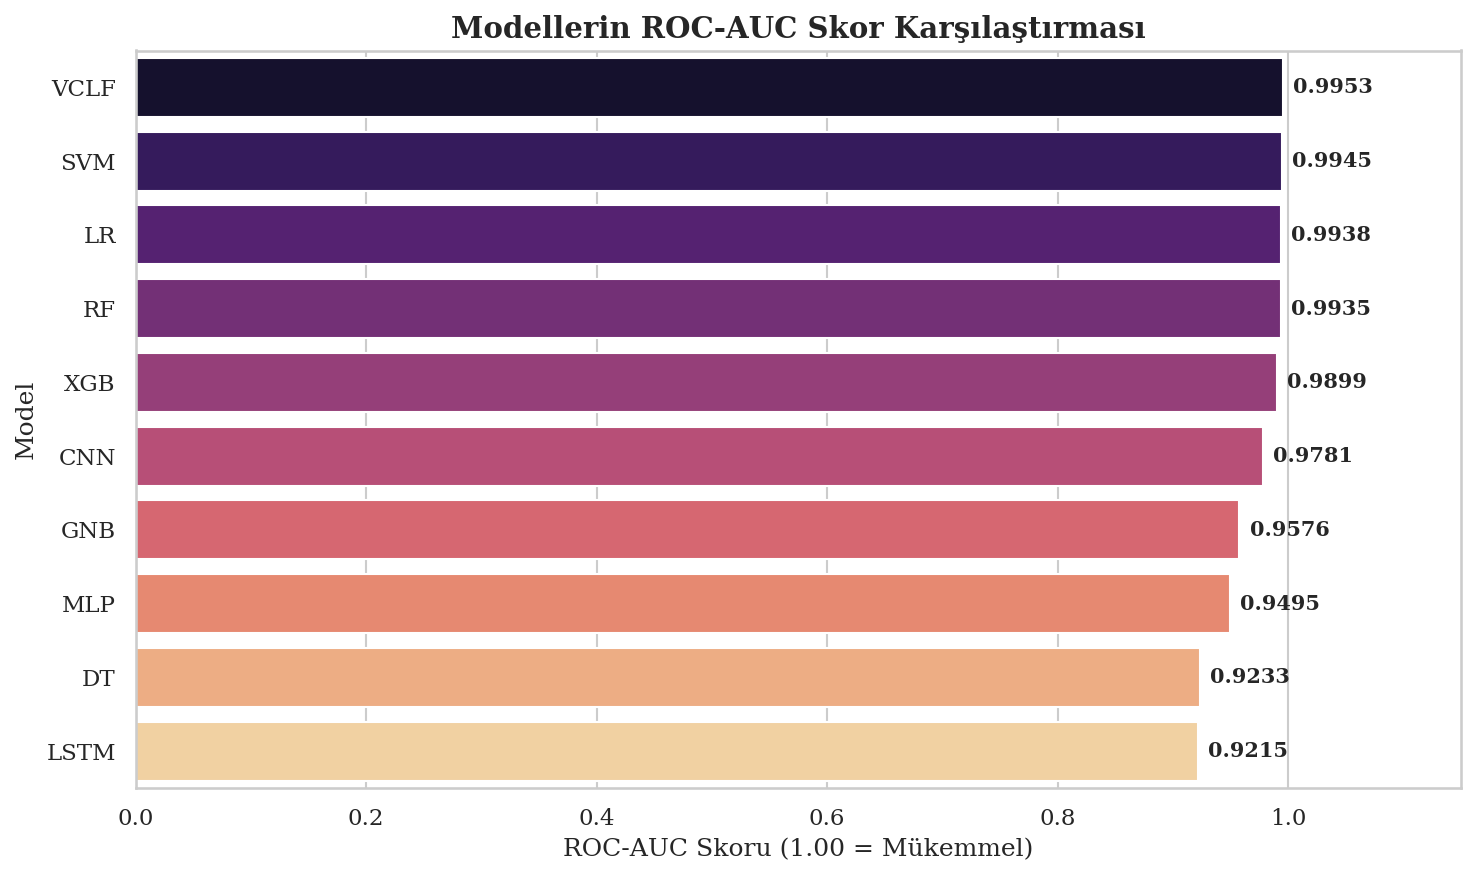

✅ Grafik kaydedildi: /Users/melih/Desktop/sleep-project/sleep-disorder-signal-processing/results/figures/roc_auc_scores_bar_baseline.png


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Görsel Ayarları
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.family"] = "serif"

# Dosya Yolu
METRICS_PATH = "/Users/melih/Desktop/sleep-project/sleep-disorder-signal-processing/results/tables-baseline/baseline_metrics.csv"

print("📊 Modellerin ROC-AUC Skorları Karşılaştırılıyor (CSV'den Okunuyor)...")

if os.path.exists(METRICS_PATH):
    # 1. CSV'yi Oku
    df = pd.read_csv(METRICS_PATH)
    
    # 2. ROC AUC Skoru boş olanları (NA) çıkar veya 0 yap
    df = df.dropna(subset=['roc_auc_ovr_macro'])
    
    # 3. Sıralama (En yüksek AUC en üstte olsun)
    df_sorted = df.sort_values(by="roc_auc_ovr_macro", ascending=False)
    
    # 4. Çizim Alanı
    plt.figure(figsize=(10, 6))
    
    # 5. Bar Plot Çizimi
    ax = sns.barplot(
        x="roc_auc_ovr_macro", 
        y="model", 
        data=df_sorted, 
        palette="magma", # Renk paleti (Magma: Koyu mor -> Turuncu)
        hue="model",
        legend=False
    )
    
    # 6. Başlık ve Etiketler
    plt.title("Modellerin ROC-AUC Skor Karşılaştırması", fontsize=14, fontweight='bold')
    plt.xlabel("ROC-AUC Skoru (1.00 = Mükemmel)")
    plt.ylabel("Model")
    plt.xlim(0.0, 1.15) # Yazılar sığsın diye sağda boşluk
    
    # 7. Çubukların ucuna tam puanı yaz
    for container in ax.containers:
        ax.bar_label(container, fmt="%.4f", padding=5, fontsize=10, fontweight='bold')

    plt.tight_layout()
    
    # 8. Kaydet ve Göster
    save_path = "/Users/melih/Desktop/sleep-project/sleep-disorder-signal-processing/results/figures/roc_auc_scores_bar_baseline.png"
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Grafik kaydedildi: {save_path}")
    
else:
    print(f"❌ HATA: {METRICS_PATH} dosyası bulunamadı!")